In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def entry_stop_gradients(target, mask):
    mask_stop = tf.logical_not(mask)
    mask = tf.cast(mask, dtype=target.dtype)
    mask_stop = tf.cast(mask_stop, dtype=target.dtype)
    return tf.stop_gradient(mask_stop * target) + mask * target



class affine_coupling(layers.Layer):
    def __init__(self, name, n_split_at, n_width=32, flow_coupling=0, **kwargs):
        super(affine_coupling, self).__init__(name=name, **kwargs)
        self.n_split_at = n_split_at
        self.flow_coupling = flow_coupling
        self.n_width = n_width

    def build(self, input_shape):
        n_length = input_shape[-1]
        if self.flow_coupling == 0:
            self.f = NN2('a2b', self.n_width, n_length-self.n_split_at)
        elif self.flow_coupling == 1:
            self.f = NN2('a2b', self.n_width, (n_length-self.n_split_at)*2)
        else:
            raise Exception()
        self.log_gamma = self.add_weight(name='log_gamma', shape=(
            1, n_length-self.n_split_at), initializer=tf.zeros_initializer(), dtype=tf.float32, trainable=True)

    def call(self, x, logdet=None):
        z = x
        n_split_at = self.n_split_at
        alpha = 0.6

        z1, z2 = z[:, :n_split_at], z[:, n_split_at:]

        if self.flow_coupling == 0:
            shift = self.f(z1)
            shift = tf.exp(self.log_gamma)*tf.nn.tanh(shift)
            z2 += shift
        elif self.flow_coupling == 1:
            h = self.f(z1)
            shift = h[:, ::2]
            scale = alpha*tf.nn.tanh(h[:, 1::2])
            shift = tf.exp(self.log_gamma)*tf.nn.tanh(shift)
            z2 = z2 + scale*z2 + shift
        else:
            raise ValueError(
                "Invalid flow_coupling value. Use 0 (additive) or 1 (affine).")
        if logdet is not None:
            logdet += tf.reduce_sum(tf.math.log(scale +
                                    tf.ones_like(scale)), axis=[1], keepdims=True)

        z = tf.concat([z1, z2], 1)
        if logdet is not None:
            return z, logdet

        return z

    def inverse(self, z, logdet=None):
        n_split_at = self.n_split_at
        z1, z2 = z[:, :n_split_at], z[:, n_split_at:]
        alpha = 0.6

        if self.flow_coupling == 0:
            shift = self.f(z1)
            shift = tf.exp(self.log_gamma)*tf.nn.tanh(shift)
            z2 -= shift
        elif self.flow_coupling == 1:
            h = self.f(z1)
            shift = h[:, ::2]
            scale = alpha*tf.nn.tanh(h[:, 1::2])
            shift = tf.exp(self.log_gamma)*tf.nn.tanh(shift)
            z2 = (z2 - shift) / (tf.ones_like(scale) + scale)
        else:
            raise ValueError(
                "Invalid flow_coupling value. Use 0 (additive) or 1 (affine).")
        if logdet is not None:
            logdet -= tf.reduce_sum(tf.math.log(scale +
                                    tf.ones_like(scale)), axis=[1], keepdims=True)

        z = tf.concat([z1, z2], 1)
        if logdet is not None:
            return z, logdet

        return z


class NN2(layers.Layer):
    def __init__(self, name, n_width=32, n_out=None, **kwargs):
        super(NN2, self).__init__(name=name, **kwargs)
        self.n_width = n_width
        self.n_out = n_out

    def build(self, input_shape):
        self.l_1 = layers.Dense(units=self.n_width, activation=None, name='h1')
        self.l_2 = layers.Dense(units=self.n_width, activation=None, name='h2')
        n_out = self.n_out or int(input_shape[-1])
        self.l_f = layers.Dense(units=n_out, name='last')

    def call(self, inputs):
        x = self.l_1(inputs)
        x = tf.nn.relu(x)
        x = self.l_2(x)
        x = tf.nn.relu(x)
        x = self.l_f(x)
        # #Option for Tanh with high regularity (commented out)
        # x = tf.nn.tanh(self.l_1(inputs))
        # x = tf.nn.tanh(self.l_2(x))
        return x


class NN2v(layers.Layer):
    def __init__(self, name, n_width=32, n_out=None, **kwargs):
        super(NN2v, self).__init__(name=name, **kwargs)
        self.n_width = n_width
        self.n_out = n_out

    def build(self, input_shape):
        self.l_1 = layers.Dense(units=self.n_width, activation=None, name='h1')
        self.l_2 = layers.Dense(units=self.n_width//2,
                                activation=None, name='h2')
        self.l_3 = layers.Dense(units=self.n_width//2,
                                activation=None, name='h3')
        self.l_4 = layers.Dense(units=self.n_width, activation=None, name='h4')
        n_out = self.n_out or int(input_shape[-1])
        self.l_f = layers.Dense(units=n_out, name='last')

    def call(self, inputs):
        x = tf.nn.relu(self.l_1(inputs))
        x = tf.nn.relu(self.l_2(x))
        x = tf.nn.relu(self.l_3(x))
        x = tf.nn.relu(self.l_4(x))
        x = self.l_f(x)
        return x


class squeezing(layers.Layer):
    def __init__(self, name, n_dim, n_cut=1, **kwargs):
        super(squeezing, self).__init__(name=name, **kwargs)
        self.n_dim = n_dim
        self.n_cut = n_cut
        self.x = None

    def call(self, inputs):
        z = inputs
        n_length = z.get_shape()[-1]

        if self.n_length < self.n_cut and not self.x:
            raise Exception()
        if self.n_dim == n_length:
            if n_length > self.n_cut:
                if self.x:
                    raise Exception()
                else:
                    self.x = z[:, n_length - self.n_cut:]
                    z = z[:, :n_length - self.n_cut]
            else:
                self.x = None
        elif self.n_length <= self.n_cut:
            z = tf.concat([z, self.x], 1)
            self.x = None
        else:
            cut = z[:, n_length - self.n_cut:]
            self.x = tf.concat([cut, self.x], 1)
            z = z[:, :n_length - self.n_cut]
        return z

    def inverse(self, inputs):
        z = inputs
        n_length = z.get_shape()[-1]

        if self.n_dim == n_length:
            n_start = self.n_dim % self.n_cut
            n_start += self.n_cut if n_start == 0 else 0
            self.x = z[:, n_start:]
            z = z[:, :n_start]
        else:
            x_length = self.x.get_shape()[-1]
            if x_length < self.n_cut:
                raise Exception()
            cut = self.x[:, :self.n_cut]
            z = tf.concat([z, cut], 1)
            if x_length - self.n_cut == 0:
                self.x = None
            else:
                self.x = self.x[:, self.n_cut:]
        return z


class squeezing2(layers.Layer):
    def __init__(self, name, n_dim, n_cut=1, **kwargs):
        super(squeezing2, self).__init__(name=name, **kwargs)
        self.n_dim = n_dim
        self.n_cut = n_cut
        self.x = None

    def call(self, inputs):
        z = inputs
        # print(z.get_shape())
        n_length = z.get_shape()[-1]

        if n_length < self.n_cut and not self.x:
            raise Exception()

        if self.n_dim == n_length:
            if n_length > 2*self.n_cut:
                if self.x != None:
                    raise Exception()
                else:
                    self.x = z[:, n_length - self.n_cut:]
                    z = z[:, :n_length - self.n_cut]
            else:
                self.x = None
        elif n_length <= 2*self.n_cut:
            z = tf.concat([z, self.x], 1)
            self.x = None
        else:
            cut = z[:, n_length - self.n_cut:]
            self.x = tf.concat([cut, self.x], 1)
            z = z[:, :n_length - self.n_cut]
        return z

    def inverse(self, inputs):
        z = inputs
        n_length = z.get_shape()[-1]
        if self.n_dim == n_length:
            n_start = self.n_dim % self.n_cut
            if n_start == 0:
                n_start += self.n_cut
            self.x = z[:, n_start:]
            z = z[:, :n_start]

        x_length = self.x.get_shape()[-1]
        if x_length < self.n_cut:
            raise Exception()
        cut = self.x[:, :self.n_cut]
        z = tf.concat([z, cut], 1)
        if x_length - self.n_cut == 0:
            self.x = None
        else:
            self.x = self.x[:, self.n_cut:]
        return z


class W_LU(layers.Layer):
    def __init__(self, name, **kwargs):
        super(W_LU, self).__init__(name=name, **kwargs)

    def build(self, input_shape):
        self.n_length = input_shape[-1]
        self.LU = self.add_weight(name='LU', shape=(self.n_length, self.n_length),initializer=tf.keras.initializers.RandomNormal(stddev=0.05), dtype=tf.float32, trainable=True)
        self.LU_init = self.add_weight(name="LU_init", shape=(
            self.n_length, self.n_length), initializer=tf.keras.initializers.Identity(), trainable=False, dtype=tf.float32)

    def call(self, inputs, logdet=None, reverse=False):
        x = inputs
        n_dim = x.shape[-1]
        LU = self.LU_init + self.LU

        U = tf.linalg.band_part(LU, 0, -1)
        U_diag = tf.linalg.tensor_diag_part(U) 
        U_mask = (tf.linalg.band_part(tf.ones([n_dim, n_dim]), 0, -1) >= 1)
        U = entry_stop_gradients(U, U_mask)

        I = tf.eye(self.n_length, dtype=tf.float32)
        L = tf.linalg.band_part(I+LU, -1, 0)-tf.linalg.band_part(LU, 0, 0)
        L_mask = (tf.linalg.band_part(tf.ones(
            [n_dim, n_dim]), -1, 0) - tf.linalg.band_part(tf.ones([n_dim, n_dim]), 0, 0) >= 1)
        L = entry_stop_gradients(L, L_mask)

        if not reverse:
            x = tf.transpose(x)
            x = tf.linalg.matmul(U, x)
            x = tf.linalg.matmul(L, x)
            x = tf.transpose(x)
        else:
            x = tf.transpose(x)
            x = tf.linalg.matmul(tf.linalg.inv(L), x)
            x = tf.linalg.matmul(tf.linalg.inv(U), x)
            x = tf.transpose(x)

        if logdet is not None:
            dlogdet = tf.reduce_sum(tf.math.log(tf.math.abs(U_diag)))
            if reverse:
                dlogdet *= -1.0
            return x, logdet + dlogdet
        return x


class flow_mapping(layers.Layer):
    def __init__(self, name, n_depth, n_split_at, n_width=32, flow_coupling=0, n_bins=16, **kwargs):
        super(flow_mapping, self).__init__(name=name, **kwargs)
        self.n_depth = n_depth
        self.n_split_at = n_split_at
        self.n_width = n_width
        self.flow_coupling = flow_coupling
        self.n_bins = n_bins
        assert n_depth % 2 == 0

    def build(self, input_shape):
        self.n_length = input_shape[-1]
        self.affine_layers = []
        self.scale_layers = []

        sign = -1
        for i in range(self.n_depth):
            if i%1 == 0:
                self.scale_layers.append(actnorm('actnorm'+str(i)))
            sign *= -1
            i_split_at = (self.n_split_at*sign + self.n_length) % self.n_length
            self.affine_layers.append(affine_coupling('af_coupling_' + str(i),i_split_at,n_width=self.n_width,flow_coupling=self.flow_coupling))
            # if self.n_bins > 0:
            #   self.cdf_layer = CDF_quadratic('cdf_layer', self.n_bins)

    def call(self, inputs, logdet=None, reverse=False):
        z = inputs
        if not reverse:
            for i in range(self.n_depth):
                if i%1  == 0:
                    scale_index = i//1
                    z = self.scale_layers[scale_index](z,logdet)
                    if logdet is not None:
                        z, logdet = z
                
                z = self.affine_layers[i](z, logdet)
                if logdet is not None:
                    z, logdet = z
                z = z[:, ::-1]
        else:
            for i in reversed(range(self.n_depth)):
                z = z[:, ::-1]
                z = self.affine_layers[i].inverse(z, logdet)
                if logdet is not None:
                    z, logdet = z
                
                if i%1  == 0:
                    scale_index = i//1
                    z = self.scale_layers[scale_index](z, logdet, reverse=True)
                    if logdet is not None:
                        z, logdet = z
        if logdet is not None:
            return z, logdet
        return z
    def actnorm_data_initialization(self):
        for i in range(self.n_depth):
            if i%1 == 0:
                self.scale_layers[i//1].reset_data_initialization()

class actnorm(layers.Layer):
    def __init__(self,name,scale = 1,logscale_factor = 3.0,**kwargs):
        super(actnorm, self).__init__(name=name,**kwargs)
        self.scale = scale
        self.logscale_factor = logscale_factor
        self.data_init = True
        
    def build(self, input_shape):
        self.n_length = input_shape[-1]
        self.b = self.add_weight(name='b', shape=(1, self.n_length),initializer=tf.zeros_initializer(),dtype=tf.float32, trainable=True)
        self.b_init = self.add_weight(name='b_init', shape=(1, self.n_length),initializer=tf.zeros_initializer(),dtype=tf.float32, trainable=False)
        self.logs  = self.add_weight(name='logs', shape=(1, self.n_length),initializer=tf.zeros_initializer(),dtype=tf.float32, trainable=True)
        self.logs_init = self.add_weight(name='logs_init', shape=(1, self.n_length),initializer=tf.zeros_initializer(),dtype=tf.float32, trainable=False)
        
    def call(self, inputs, logdet = None, reverse = False):
        # data initialization
        # # by default, no data initialization is implemented.
        if not self.data_init:
            x_mean = tf.reduce_mean(inputs, [0], keepdims=True)
            x_var = tf.reduce_mean(tf.square(inputs-x_mean), [0], keepdims=True)
            # x_var = tf.reshape(x_var, (1, -1))
            # adjusted_variance = tf.where(
                # tf.reshape(tf.range(x_var.shape[1]) < 12, (1, x_var.shape[1])),  # ✅ Reshape condition to match x_var
                # tf.maximum(x_var, 0.005), 
                # x_var
                # )

            
            self.b_init.assign(-x_mean)
            self.logs_init.assign(tf.math.log(self.scale/(tf.sqrt(x_var)+1e-6))/self.logscale_factor)
            
            self.data_init = True
        if not reverse:
            x = inputs + (self.b + self.b_init)
            x = x * tf.exp(self.logs + self.logs_init)
        else:
            x = inputs * tf.exp(-self.logs - self.logs_init)
            x = x - (self.b + self.b_init)
        
        if logdet is not None:
            dlogdet = tf.reduce_sum(self.logs + self.logs_init)
            if reverse:
                dlogdet *= -1
            return x, logdet + dlogdet
        
        return x
    def reset_data_initialization(self):
        self.data_init = False

In [3]:
# Given arrays
array1 = np.array([[-4.     ], [ 0.52868], [ 2]])
array2 = np.array([[ -1.99308], [ 1.84921], [ 3.]])
array3 = np.array([[-3.59], [-1.49317], [ 5.     ]])

# Extract first and last elements from each array
first_last = [
    [array1[0, 0], array1[-1, 0]],  # First and last from array1
    [array2[0, 0], array2[-1, 0]],  # First and last from array2
    [array3[0, 0], array3[-1, 0]]   # First and last from array3
]

# Generate all 8 possible (1,3) vectors
combinations = []
for i in range(2):  # Pick first or last from array1
    for j in range(2):  # Pick first or last from array2
        for k in range(2):  # Pick first or last from array3
            combinations.append([first_last[0][i], first_last[1][j], first_last[2][k]])

# Convert to (8,3) NumPy array
combinations = np.array(combinations)

# Expand to (8,15) by padding zeros in the remaining 12 columns
expanded_matrix = np.zeros((8, 15))
expanded_matrix[:, :3] = combinations  # Assign first 3 columns

In [4]:
class krnet(tf.keras.Model):
    def __init__(self, name, n_dim, n_step, n_depth, n_width=32, shrink_rate=1.0, flow_coupling=0, n_bins=16, rotation=False, **kwargs):
        super(krnet, self).__init__(name=name, **kwargs)
        assert n_depth % 2 == 0
        # tfd = tfp.distributions
        # prior = tfd.MultivariateNormalDiag(loc=tf.zeros(n_dim),scale_diag=tf.ones(n_dim))

        self.n_dim = n_dim
        self.n_step = n_step
        self.n_depth = n_depth
        self.n_width = n_width
        self.n_bins = n_bins
        self.shrink_rate = shrink_rate
        self.flow_coupling = flow_coupling
        self.rotation = rotation
        self.Max = tf.convert_to_tensor(expanded_matrix,dtype=tf.float32)
        ######
        self.weights_1 = [0.2, 0.8]
        self.means_1 = [-4, 2]
        self.stds_1 = [0.73, 1.09]
        
        self.weights_2 = [0.4, 0.6]
        self.means_2 = [-2, 3]
        self.stds_2 = [0.91, 1.51]
        
        self.weights_3 = [0.134, 0.866]
        self.means_3 = [5, -3.59]
        self.stds_3 = [1.33, 0.54]
        

        ######

        self.n_stage = n_dim // n_step
        if n_dim % n_step == 0:
            self.n_stage -= 1
        self.n_rotation = self.n_stage

        if rotation:
            self.rotations = []
            for i in range(self.n_rotation):
                self.rotations.append(W_LU('rotation'+str(i)))

        self.flow_mappings = []
        for i in range(self.n_stage):
            n_split_at = n_dim - (i+1) * n_step
            self.flow_mappings.append(flow_mapping('flow_mapping'+str(i),
                                                   n_depth,
                                                   n_split_at,
                                                   n_width=n_width,
                                                   flow_coupling=flow_coupling,
                                                   n_bins=n_bins))
            n_width = int(n_width*self.shrink_rate)

        self.squeezing_layer = squeezing2('squeezing', n_dim, n_step)
        # self.log_prior = self.prior.log_prob

    def call(self, inputs):
        # print('call invoke')
        objective = tf.zeros_like(inputs, dtype='float32')[:, 0]
        objective = tf.reshape(objective, [-1, 1])
        z, objective = self.mapping_to_prior(inputs, objective)
        objective += tf.reshape(self.compute_prior_log_prob(z), [-1, 1])
        return objective

    def compute_prior_log_prob(self, samples):
        """
        Compute the log probability under the mixture Gaussian prior.
        :param samples: Tensor of shape (n_samples, n_dim).
        :return: Tensor of log probabilities of shape (n_samples,).
        """
        dim_1 = samples[:, 0]
        dim_2 = samples[:, 1]
        dim_3 = samples[:, 2]
        gaussian_dims = samples[:,3:]

        # Compute mixture Gaussian log probabilities for first three dimensions
        log_pdf_1 = self._compute_mixture_pdf(
            dim_1, self.weights_1, self.means_1, self.stds_1)
        log_pdf_2 = self._compute_mixture_pdf(
            dim_2, self.weights_2, self.means_2, self.stds_2)
        log_pdf_3 = self._compute_mixture_pdf(
            dim_3, self.weights_3, self.means_3, self.stds_3)
        

        # Compute Gaussian log PDF for remaining dimensions
        log_pdf_gaussian = tf.reduce_sum(-0.5 * gaussian_dims **2 - tf.math.log(tf.sqrt(2 * np.pi)), axis=1)

        # Combine log probabilities
        log_prior =  log_pdf_gaussian + log_pdf_1 + log_pdf_2 + log_pdf_3 
        return log_prior

    def _compute_mixture_pdf(self, samples, weights, means, stds):
        """
        Compute the log PDF for a mixture of Gaussians in a numerically stable way.
        :param samples: Input tensor of shape (n_samples,).
        :param weights: List or Tensor of mixture weights.
        :param means: List or Tensor of means for each Gaussian component.
        :param stds: List or Tensor of standard deviations for each Gaussian component.
        :return: Log PDF of the mixture for each sample.
        """
        weights = tf.constant(weights, dtype=tf.float32)
        means = tf.constant(means, dtype=tf.float32)
        stds = tf.constant(stds, dtype=tf.float32)

        # Expand dimensions to match samples shape for broadcasting
        samples = tf.expand_dims(samples, axis=-1)  # Shape: (n_samples, 1)
        means = tf.expand_dims(means, axis=0)       # Shape: (1, n_components)
        stds = tf.expand_dims(stds, axis=0)         # Shape: (1, n_components)

        # Compute log probabilities for each component
        log_probs = -0.5 * ((samples - means) / stds) ** 2 - \
            tf.math.log(stds * tf.sqrt(2 * np.pi))
        log_probs += tf.math.log(weights)  # Add log weights

        # Combine log probabilities using log-sum-exp for numerical stability
        return tf.reduce_logsumexp(log_probs, axis=-1)  # Shape: (n_samples,)

    def mapping_to_prior(self, inputs, logdet=None):
        z = inputs
        # print("Mapping to prior, input shape:", z.shape)
        for i in range(self.n_stage):
            # print(f"Stage {i}, input shape before squeezing: {z.shape}")
            if logdet is not None:
                if self.rotation and i < self.n_rotation:
                    z, logdet = self.rotations[i](z, logdet)
                    # print(f"Applied rotation {i}, output shape: {z.shape}")
                z, logdet = self.flow_mappings[i](z, logdet)
                # print(f"Applied flow mapping {i}, output shape: {z.shape}")
            else:
                if self.rotation and i < self.n_rotation:
                    z = self.rotations[i](z)
                z = self.flow_mappings[i](z)
            z = self.squeezing_layer(z)
        # print("Final shape after mapping to prior:", z.shape)
        if logdet is not None:
            return z, logdet
        return z
    
    def actnorm_data_initialization(self):
        for i in range(self.n_stage):
            self.flow_mappings[i].actnorm_data_initialization()

    def mapping_from_prior(self, inputs):
        z = inputs
        for i in reversed(range(self.n_stage)):
            z = self.squeezing_layer.inverse(z)
            z = self.flow_mappings[i](z, reverse=True)
            if self.rotation and i < self.n_rotation:
                z = self.rotations[i](z, reverse=True)
        return z

    def draw_samples_from_prior(self, n_samples):
        """
        Generate samples from the prior distribution.
        :param n_samples: Number of samples to generate.
        :return: TensorFlow tensor of shape (n_samples, n_dim).
        """
        # First 3 dimensions: Mixture Gaussians
        dim_1 = self._generate_mixture_samples(
            n_samples, self.weights_1, self.means_1, self.stds_1)
        dim_2 = self._generate_mixture_samples(
            n_samples, self.weights_2, self.means_2, self.stds_2)
        dim_3 = self._generate_mixture_samples(
            n_samples, self.weights_3, self.means_3, self.stds_3)
    
        # Last (n_dim - 3) dimensions: Standard Gaussian
        gaussian_dims = tf.random.normal(
            shape=(n_samples, self.n_dim - 3), mean=0.0, stddev=1)

        # Combine all dimensions into a single tensor of shape (n_samples, n_dim)
        random_variable = tf.concat([
            tf.expand_dims(dim_1, axis=-1),  # Shape: (n_samples, 1)
            tf.expand_dims(dim_2, axis=-1),  # Shape: (n_samples, 1)
            tf.expand_dims(dim_3, axis=-1),  # Shape: (n_samples, 1)
            gaussian_dims
        ], axis=1)

        return self.mapping_from_prior(random_variable)
    
    
    def _generate_mixture_samples(self, n_samples, weights, means, stds):
        """
        Generate samples from a 1D mixture of Gaussians.
        :param n_samples: Number of samples to generate.
        :param weights: List of mixture weights.
        :param means: List of means for each Gaussian component.
        :param stds: List of standard deviations for each Gaussian component.
        :return: TensorFlow tensor of shape (n_samples,).
        """
        # Convert weights, means, and stds to TensorFlow tensors
        weights = tf.constant(weights, dtype=tf.float32)
        means = tf.constant(means, dtype=tf.float32)
        stds = tf.constant(stds, dtype=tf.float32)

        # Number of components in the mixture
        n_components = tf.shape(weights)[0]

        # Sample component indices based on the mixture weights
        components = tf.random.categorical(tf.math.log(
            [weights]), n_samples)  # Shape: (1, n_samples)
        components = tf.reshape(components, [-1])  # Shape: (n_samples,)

        # Gather means and standard deviations for the sampled components
        sampled_means = tf.gather(means, components)  # Shape: (n_samples,)
        sampled_stds = tf.gather(stds, components)    # Shape: (n_samples,)

        # Sample from the corresponding Gaussian components
        samples = tf.random.normal(shape=(
            n_samples,), mean=sampled_means, stddev=sampled_stds)  # Shape: (n_samples,)

        return samples



In [5]:
def dihedral_angles(data,indices):
    """
    Calculate dihedral angles for multiple sets of four specific points in 3D space.
    
    Parameters:
        data: An array of shape (n, 66), where n is the number of samples,
              and each sample contains 66 values (22 points in 3D space).
    
    Returns:
        Array of dihedral angles in degrees.
    """
    # Reshape data to (n, 22, 3) assuming 22 points with (x, y, z) coordinates
    m,n = data.shape
    data = data.reshape(-1, n//3, 3)
    
    # Extract relevant points (5,7,9,15) - converting from 1-based to 0-based indices
    indices = [i-1 for i in indices]
    pairs = data[:, indices, :]
    
    # Compute bond vectors
    b = np.diff(pairs, axis=1)
    
    # Compute normal vectors
    n1 = np.cross(b[:, 0], b[:, 1])
    n2 = np.cross(b[:, 1], b[:, 2])
    
    # Normalize normal vectors
    n1 /= np.linalg.norm(n1, axis=1, keepdims=True)
    n2 /= np.linalg.norm(n2, axis=1, keepdims=True)
    
    # Compute the cosine and sine of the dihedral angles
    cos_phi = np.sum(n1 * n2, axis=1)
    sin_phi = np.sum(np.cross(n1, n2) * (b[:, 1] / np.linalg.norm(b[:, 1], axis=1, keepdims=True)), axis=1)
    
    # Compute the dihedral angles in radians and convert to degrees
    return np.arctan2(sin_phi, cos_phi)

In [6]:
def dihedral_angles_tf(data, indices):
    """
    Compute dihedral angles for multiple sets of four specific points in 3D space using TensorFlow.
    
    Parameters:
        data (tf.Tensor): Tensor of shape (n_samples, n_features), where each sample has 3D coordinates.
        indices (list): List of 4 indices specifying the atoms used to compute the dihedral angle.
    
    Returns:
        tf.Tensor: Tensor of dihedral angles (radians) of shape (n_samples,).
    """
    n_features = tf.shape(data)[1]
    
    # Reshape data to (n_samples, num_atoms, 3), assuming num_atoms = n_features / 3
    data = tf.reshape(data, [-1, n_features // 3, 3])
    
    # Extract relevant atom positions based on provided indices (convert to zero-based index)
    indices = [i - 1 for i in indices]
    points = tf.gather(data, indices, axis=1)  # Shape: (n_samples, 4, 3)
    
    # Compute bond vectors
    b1 = points[:, 1] - points[:, 0]
    b2 = points[:, 2] - points[:, 1]
    b3 = points[:, 3] - points[:, 2]

    # Compute normal vectors
    n1 = tf.linalg.cross(b1, b2)
    n2 = tf.linalg.cross(b2, b3)

    # Normalize normal vectors
    n1 = n1 / (tf.linalg.norm(n1, axis=1, keepdims=True) + 1e-6)
    n2 = n2 / (tf.linalg.norm(n2, axis=1, keepdims=True) + 1e-6)

    # Compute the cosine and sine of the dihedral angle
    cos_phi = tf.reduce_sum(n1 * n2, axis=1)
    sin_phi = tf.reduce_sum(tf.linalg.cross(n1, n2) * (b2 / (tf.linalg.norm(b2, axis=1, keepdims=True) + 1e-6)), axis=1)

    # Compute the dihedral angles in radians
    return tf.atan2(sin_phi, cos_phi)


In [7]:
def kde_tensorflow(x, samples, bandwidth=0.1):
    """
    Compute Kernel Density Estimation (KDE) in TensorFlow.
    
    Parameters:
        x (tf.Tensor): Points where the KDE is evaluated.
        samples (tf.Tensor): Sampled dihedral angles.
        bandwidth (float): Smoothing parameter for KDE.
    
    Returns:
        tf.Tensor: KDE values at x.
    """
    x = tf.expand_dims(x, axis=1)  # Shape: (N, 1)
    samples = tf.expand_dims(samples, axis=0)  # Shape: (1, M)

    # Apply Gaussian kernel
    kernel = tf.exp(-0.5 * tf.square((x - samples) / bandwidth)) / (bandwidth * tf.sqrt(2.0 * np.pi))
    
    return tf.reduce_mean(kernel, axis=1)  # Average over all samples


In [8]:

train_set = np.load('./data/adjusted_data_500w.npy')[:4900000]
Angles_t_phi = dihedral_angles(train_set,[1, 2, 3, 4])
Angles_t_psi = dihedral_angles(train_set,[2, 3, 4, 5])

eval_points = tf.cast(tf.linspace(-np.pi, np.pi, 100), dtype=tf.float32)

Angles_t_phi = tf.cast(Angles_t_phi, dtype=tf.float32)
Angles_t_psi = tf.cast(Angles_t_psi, dtype=tf.float32)

# ✅ Now it will work
real_density = kde_tensorflow(eval_points, Angles_t_phi, bandwidth=0.1)
real_density_psi = kde_tensorflow(eval_points, Angles_t_psi, bandwidth=0.1)



2025-05-11 23:38:09.527633: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-11 23:38:10.253983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79085 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0


In [9]:
atoms_of_interest = [5, 7, 9, 15, 17]  # 1-based indices for the atoms
cols = []

for atom in atoms_of_interest:
    start_col = 3 * (atom - 1)  # zero-based column index
    cols.extend([start_col, start_col + 1, start_col + 2])

masses = [0, 1.008, 12.01, 1.008, 1.008, 12.01, 16, 14.01, 1.008, 12.01, 1.008, 12.01, 1.008, 1.008, 1.008, 12.01, 16, 14.01, 1.008, 12.01, 1.008, 1.008, 1.008]  # Mass values from input

masses = np.array(masses)
masses = masses[atoms_of_interest]

In [10]:
def compute_end_to_end_distance_and_rg_centered(samples, masses):
    """
    Computes the end-to-end distance and radius of gyration (Rg) for each molecule.
    Assumes input samples are already centered at the center of mass (COM).

    Parameters:
        samples: numpy array of shape (n, 15), where each row contains (x, y, z) coordinates of 5 atoms.
        masses: numpy array of shape (5,), containing atomic masses for each of the 5 atoms.

    Returns:
        end_to_end_distances: numpy array of shape (n,), end-to-end distances.
        rg_values: numpy array of shape (n,), radius of gyration values.
    """
    num_atoms = samples.shape[1] // 3  # Assuming 3D coordinates per atom
    positions = samples.reshape(-1, num_atoms, 3)  # Reshape to (n, num_atoms, 3)

    # Compute end-to-end distance (distance between first and last atom)
    end_to_end_distances = np.linalg.norm(positions[:, -1, :] - positions[:, 0, :], axis=1)

    # Compute Radius of Gyration (Rg) - since samples are already centered, just mass-weighted norm
    mass_sum = np.sum(masses)
    squared_distances = np.linalg.norm(positions, axis=2) ** 2  # Squared distances (n, num_atoms)
    rg_values = np.sqrt(np.sum(masses * squared_distances, axis=1) / mass_sum)

    return end_to_end_distances, rg_values


end_to_end, rg = compute_end_to_end_distance_and_rg_centered(train_set, masses)
print([min(end_to_end),max(end_to_end)])
print([min(rg),max(rg)])



end_to_end = tf.cast(end_to_end, dtype=tf.float32)
rg = tf.cast(rg, dtype=tf.float32)




[0.2742470128120173, 0.5175522228367173]
[0.13821460874384023, 0.18840414381334486]


In [11]:
def compute_end_to_end_distance_and_rg_centered_tf(samples, masses):
    """
    Computes the end-to-end distance and radius of gyration (Rg) for each molecule in TensorFlow.
    Assumes input samples are already centered at the center of mass (COM).

    Parameters:
        samples: Tensor of shape (n, 15), where each row contains (x, y, z) coordinates of 5 atoms.
        masses: Tensor of shape (5,), containing atomic masses for each of the 5 atoms.

    Returns:
        end_to_end_distances: Tensor of shape (n,), end-to-end distances.
        rg_values: Tensor of shape (n,), radius of gyration values.
    """
    num_atoms = tf.shape(samples)[1] // 3  # Assuming 3D coordinates per atom
    positions = tf.reshape(samples, [-1, num_atoms, 3])  # Reshape to (n, num_atoms, 3)

    # Compute end-to-end distance (distance between first and last atom)
    end_to_end_distances = tf.norm(positions[:, -1, :] - positions[:, 0, :], axis=1)

    # Compute Radius of Gyration (Rg) - since samples are already centered, just mass-weighted norm
    mass_sum = tf.reduce_sum(masses)
    squared_distances = tf.reduce_sum(tf.square(positions), axis=2)  # Squared distances (n, num_atoms)
    rg_values = tf.sqrt(tf.reduce_sum(masses * squared_distances, axis=1) / mass_sum)

    return end_to_end_distances, rg_values


masses_tf = tf.convert_to_tensor(masses, dtype=tf.float32)



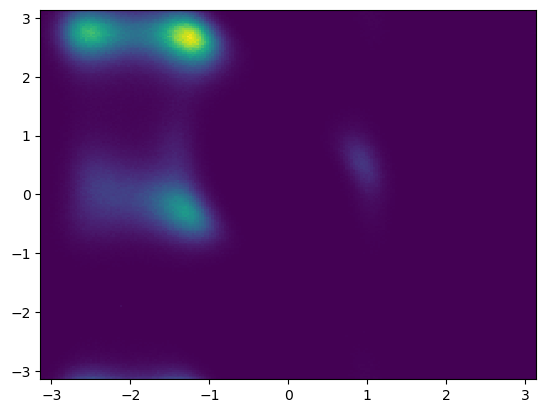

In [12]:
def kde_tensorflow_2D(x, samples, bandwidth=0.1):
    """
    Compute Kernel Density Estimate (KDE) using Gaussian kernels in TensorFlow.
    Supports 1D and 2D KDE.
    """
    x = tf.cast(x, dtype=tf.float32)  # Ensure x is float32
    samples = tf.cast(samples, dtype=tf.float32)  # Ensure samples is float32
    bandwidth = tf.cast(bandwidth, dtype=tf.float32)  # Ensure bandwidth is float32

    # ✅ Expand dimensions correctly for broadcasting
    x = tf.expand_dims(x, axis=1)  # Shape: (100, 1, D) if 2D
    samples = tf.expand_dims(samples, axis=0)  # Shape: (1, 40000, D) if 2D

    # Apply Gaussian kernel
    kernel = tf.exp(-0.5 * tf.reduce_sum(tf.square((x - samples) / bandwidth), axis=-1)) / (bandwidth * tf.sqrt(2.0 * np.pi))

    return tf.reduce_mean(kernel, axis=1)  # KDE estimate

with tf.device("/CPU:0"):
    samples_2D = tf.stack([Angles_t_phi, Angles_t_psi], axis=1)  # Shape: (N, 2)
    x_vals = np.linspace(-np.pi, np.pi, 20)
    y_vals = np.linspace(-np.pi, np.pi, 20)
    X, Y = np.meshgrid(x_vals, y_vals)
    eval_points_2D = np.column_stack([X.ravel(), Y.ravel()])
    eval_points_tf_2D = tf.convert_to_tensor(eval_points_2D, dtype=tf.float32)
    hist_2D = kde_tensorflow_2D(eval_points_tf_2D, samples_2D, bandwidth=0.1)

hist = plt.hist2d(samples_2D[:, 0], samples_2D[:, 1], bins=200, density=True)




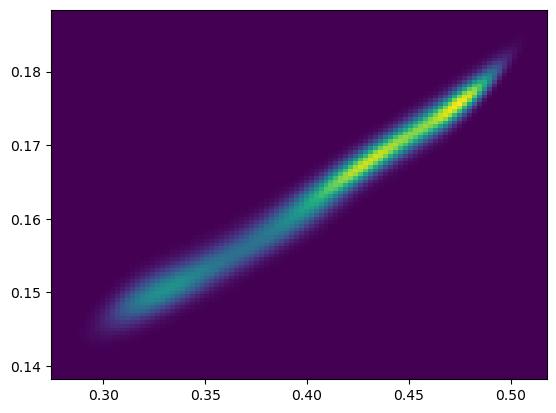

In [13]:
with tf.device("/CPU:0"):
    samples_2D_eer = tf.stack([end_to_end, rg], axis=1)  # Shape: (N, 2)
    x_vals = np.linspace(0.2729206457179367, 0.5175522228367173, 20)
    y_vals = np.linspace(0.13821460874384023, 0.18840414381334486, 20)
    X, Y = np.meshgrid(x_vals, y_vals)
    eval_points_2D_eer = np.column_stack([X.ravel(), Y.ravel()])
    eval_points_tf_2D_eer = tf.convert_to_tensor(eval_points_2D_eer, dtype=tf.float32)
    hist_2D_eer = kde_tensorflow_2D(eval_points_tf_2D_eer, samples_2D_eer, bandwidth=0.001)

hist = plt.hist2d(samples_2D_eer[:, 0], samples_2D_eer[:, 1], bins=100, density=True)

In [14]:
eval_points_ee = tf.cast(tf.linspace(0.2729206457179367, 0.5175522228367173, 100), dtype=tf.float32)
eval_points_rg = tf.cast(tf.linspace(0.13821460874384023, 0.18840414381334486, 100), dtype=tf.float32)


# ✅ Now it will work
real_density_ee = kde_tensorflow(eval_points_ee, end_to_end, bandwidth=0.001)
real_density_rg = kde_tensorflow(eval_points_rg, rg, bandwidth=0.001)

In [15]:
def draw_samples_from_prior(n_samples):
        """
        Generate samples from the prior distribution.
        :param n_samples: Number of samples to generate.
        :return: TensorFlow tensor of shape (n_samples, n_dim).
        """
        # First 3 dimensions: Mixture Gaussians
        dim_1 = flow._generate_mixture_samples(
            n_samples, flow.weights_1, flow.means_1, flow.stds_1)
        dim_2 = flow._generate_mixture_samples(
            n_samples, flow.weights_2, flow.means_2, flow.stds_2)
        dim_3 = flow._generate_mixture_samples(
            n_samples, flow.weights_3, flow.means_3, flow.stds_3)
    
        # Last (n_dim - 3) dimensions: Standard Gaussian
        gaussian_dims = tf.random.normal(
            shape=(n_samples, flow.n_dim - 3), mean=0.0, stddev=1)

        # Combine all dimensions into a single tensor of shape (n_samples, n_dim)
        random_variable = tf.concat([
            tf.expand_dims(dim_1, axis=-1),  # Shape: (n_samples, 1)
            tf.expand_dims(dim_2, axis=-1),  # Shape: (n_samples, 1)
            tf.expand_dims(dim_3, axis=-1),  # Shape: (n_samples, 1)
            gaussian_dims
        ], axis=1)

        return random_variable




In [ ]:

flow = krnet('krnet',15,2,12,n_width=64,n_bins= 0,shrink_rate=1,flow_coupling=1,rotation=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
dummy_input = np.load('./data/atom_5/set_'+str(0)+'.npy')  
flow(dummy_input)
flow.actnorm_data_initialization()
_ = flow(dummy_input)
gen_samp = draw_samples_from_prior(10000)


checkpoint = tf.train.Checkpoint(optimizer=optimizer,net = flow )
checkpoint_dir = './checkpoints'
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)  # Restore the checkpoint into flow1
    print(f"Restored checkpoint from {latest_checkpoint}")
else:
    dummy_input = np.load('./data/atom_5/set_'+str(0)+'.npy')  
    flow.build(dummy_input.shape) 
    flow.actnorm_data_initialization()
    flow(dummy_input)
    print("No checkpoint found. Starting from scratch.")

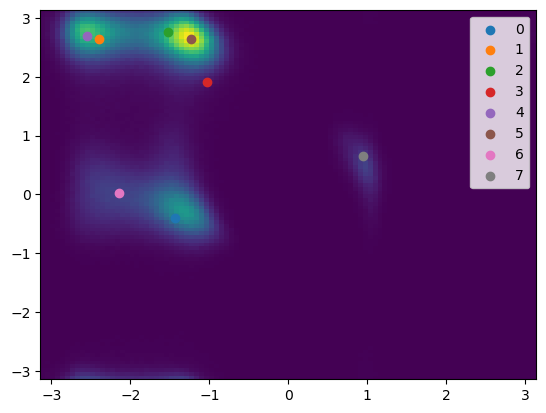

In [17]:
x_samples = flow.draw_samples_from_prior(4000000).numpy()
Angles_phi = dihedral_angles(x_samples,[1,2,3,4])
Angles_psi = dihedral_angles(x_samples,[2,3,4,5])

samples_2D_gen  = np.c_[Angles_phi,Angles_psi]

angles = dihedral_angles_tf(flow.mapping_from_prior(flow.Max),[1,2,3,4])
angles_1 = dihedral_angles_tf(flow.mapping_from_prior(flow.Max),[2,3,4,5])

plt.hist2d(samples_2D_gen[:, 0], samples_2D_gen[:, 1], bins=100, density=True)
# plt.scatter(angles,angles_1)

for i,(a,a1) in enumerate(zip(angles,angles_1)):
    plt.scatter(a,a1,label = i)
plt.legend()

In [18]:
train_set = np.load('./data/adjusted_data_500w.npy')  
min_values = np.min(train_set, axis=0)  
max_values = np.max(train_set, axis=0) 

min_values_tf = tf.convert_to_tensor(min_values, dtype=tf.float32)
max_values_tf = tf.convert_to_tensor(max_values, dtype=tf.float32)

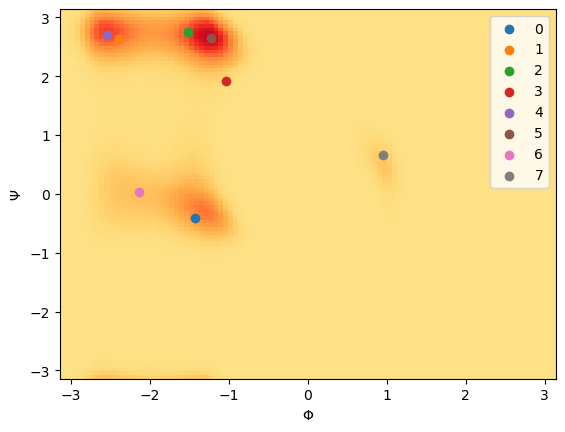

In [19]:

from matplotlib import cm
x_samples = flow.draw_samples_from_prior(4000000).numpy()
Angles_phi = dihedral_angles(x_samples,[1,2,3,4])
Angles_psi = dihedral_angles(x_samples,[2,3,4,5])

samples_2D_gen  = np.c_[Angles_phi,Angles_psi]

angles = dihedral_angles_tf(flow.mapping_from_prior(flow.Max),[1,2,3,4])
angles_1 = dihedral_angles_tf(flow.mapping_from_prior(flow.Max),[2,3,4,5])
cmap = cm.get_cmap('YlOrRd')
colors = cmap(np.linspace(0.2, 0.85, 200))  # Skip the darkest reds
light_cmap = cm.colors.ListedColormap(colors)

# warm_colors = ['red', 'darkorange', 'gold', 'tomato', 'orangered', 'crimson', 'sandybrown', 'indianred']

plt.hist2d(samples_2D_gen[:, 0], samples_2D_gen[:, 1], bins=100, density=True,cmap=light_cmap)
for i,(a,a1) in enumerate(zip(angles,angles_1)):
    # plt.scatter(a, a1, color=warm_colors[i], s=100, edgecolor='black', label=f'Max #{i+1}', zorder=3)
    plt.scatter(a,a1,label=i)


plt.xlabel(r'$\Phi$')
plt.ylabel(r'$\Psi$')
plt.legend()
plt.show()

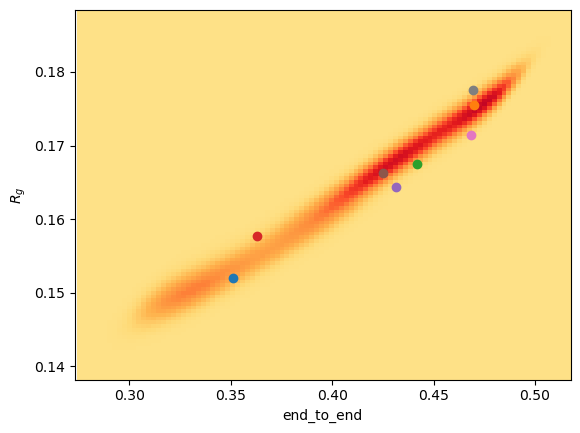

In [20]:
ee_gen,rg_gen = compute_end_to_end_distance_and_rg_centered(x_samples, masses)
samples_2D_gen_eer  = np.c_[ee_gen,rg_gen]



end_to_end_gen, gen_rg = compute_end_to_end_distance_and_rg_centered(flow.mapping_from_prior(flow.Max).numpy(), masses)

cmap = cm.get_cmap('YlOrRd')
colors = cmap(np.linspace(0.2, 0.85, 200))  # Skip the darkest reds
light_cmap = cm.colors.ListedColormap(colors)

# plt.hist2d(samples_2D_gen_eer[:, 0], samples_2D_gen_eer[:, 1], bins=100, density=True)

plt.hist2d(samples_2D_eer[:, 0], samples_2D_eer[:, 1], bins=100, density=True,cmap=light_cmap)
# plt.scatter(end_to_end_gen,gen_rg,c= 'r')
for a,a1 in zip(end_to_end_gen,gen_rg):
    plt.scatter(a,a1)
plt.xlim(0.2729206457179367, 0.5175522228367173)
plt.ylim(0.13821460874384023,0.18840414381334486)
plt.ylabel(r'$R_g$')
plt.xlabel(r'end_to_end')
plt.show()


In [21]:

pts_max = flow.Max.numpy()  # shape (8, 15)
train_set = np.load('./data/adjusted_data_500w.npy')
min_values = tf.convert_to_tensor(np.min(train_set, axis=0), dtype=tf.float32)
max_values = tf.convert_to_tensor(np.max(train_set, axis=0), dtype=tf.float32)

def sample_around_points_conditional_clipped(points, flow, min_values, max_values,
                                             n_samples_per_point=1000, std_base=0.01, std_first=0.01):
    """
    Generate samples around each point (conditional std), map them via flow,
    and keep only those that stay within [min_values, max_values].

    Returns:
        (8, n_samples_per_point, 15) array of valid mapped points
    """
    n_points, dim = points.shape
    all_valid_samples = []

    for i in range(n_points):
        std = std_first if i == 0 else std_base
        valid_samples = []

        while len(valid_samples) < n_samples_per_point:
            # Sample around point
            noise = np.random.normal(loc=0.0, scale=std, size=(n_samples_per_point, dim))
            samples = points[i] + noise
            samples_tf = tf.convert_to_tensor(samples, dtype=tf.float32)

            # Map to data space
            mapped = flow.mapping_from_prior(samples_tf)

            # Filter by bounds
            in_bounds = tf.reduce_all((mapped >= min_values) & (mapped <= max_values), axis=1)
            filtered = tf.boolean_mask(samples_tf, in_bounds)

            # Accumulate
            valid_samples.append(filtered.numpy())
            if sum(x.shape[0] for x in valid_samples) >= n_samples_per_point:
                break

        # Concatenate and trim
        full = np.concatenate(valid_samples, axis=0)[:n_samples_per_point]
        all_valid_samples.append(full)

    return np.stack(all_valid_samples, axis=0)

# Generate safe samples
safe_samples = sample_around_points_conditional_clipped(pts_max, flow,
                                                        min_values, max_values,
                                                        n_samples_per_point=5000)




In [22]:
samples_to_xs = []
for i in range(8):
    samples_to_x = flow.mapping_from_prior(tf.constant(safe_samples[i],dtype=tf.float32)).numpy()
    samples_to_xs.append(samples_to_x)

    

In [23]:
samples_dihedral = []
for i in range(8):
    phi = dihedral_angles(samples_to_xs[i],[1,2,3,4])
    psi = dihedral_angles(samples_to_xs[i],[2,3,4,5])
    samples_dihedral.append(np.c_[phi,psi])

In [24]:
samples_dihedral[0] = samples_dihedral[0][samples_dihedral[0][:,1] <0]

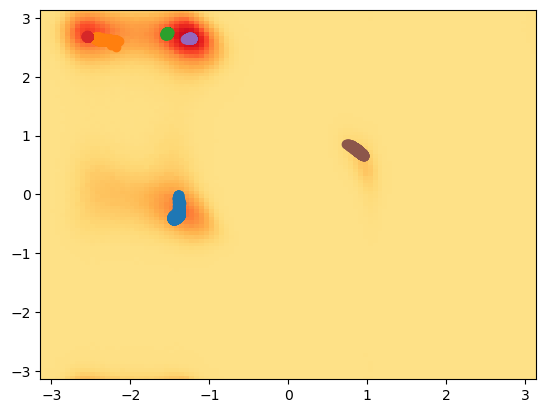

In [25]:
plt.hist2d(samples_2D_gen[:, 0], samples_2D_gen[:, 1], bins=100, density=True,cmap=light_cmap)
for i in range(8):
    if i != 6 and i !=3:
        plt.scatter(samples_dihedral[i][:,0],samples_dihedral[i][:,1])
# plt.scatter(samples_dihedral[1][:,0],samples_dihedral[1][:,1])
plt.show()

In [26]:
ee_pts = []
rg_pts = []
for i in range(8):
    ee_pt, rg_pt = compute_end_to_end_distance_and_rg_centered(samples_to_xs[i], masses)
    ee_pts.append(ee_pt)
    rg_pts.append(rg_pt)

In [27]:
ee_pts_filtered = []
rg_pts_filtered = []

for ee, rg in zip(ee_pts, rg_pts):
    ee_filtered = []
    rg_filtered = []
    for e, r in zip(ee, rg):
        if r >= 0.145:
            ee_filtered.append(e)
            rg_filtered.append(r)
    ee_pts_filtered.append(np.array(ee_filtered))
    rg_pts_filtered.append(np.array(rg_filtered))

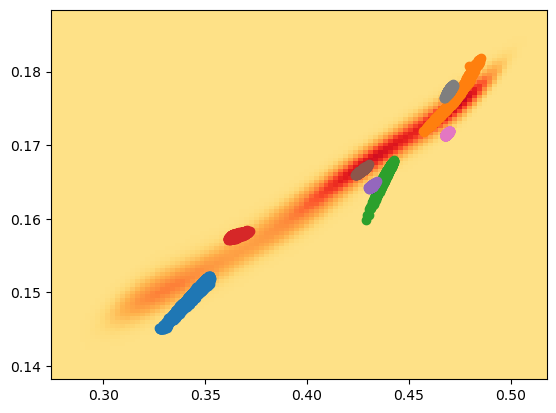

In [28]:
plt.hist2d(samples_2D_eer[:, 0], samples_2D_eer[:, 1], bins=100, density=True,cmap=light_cmap)
for i in range(8):
    plt.scatter(ee_pts_filtered[i],rg_pts_filtered[i])
plt.show()

In [29]:
X =train_set
eigvals, eigvecs = np.linalg.eigh(X.T @ X)

idx = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, idx]  # Columns are now ordered principal directions
top3_vecs = eigvecs[:, :3] 

X_proj = X @ top3_vecs          # Shape: (n, 3)
x_proj =  flow.mapping_from_prior(flow.Max).numpy() @ top3_vecs    # Shape: (8, 3)

distances = np.linalg.norm(X_proj[None, :, :] - x_proj[:, None, :], axis=-1)

# Step 4 (optional): Apply cutoff
cutoff = 0.1
mask = distances < cutoff

close_points_list = []

for i in range(8):
    close_points = X[mask[i]]  # mask[i] is a boolean array of shape (n,)
    close_points_list.append(close_points)

In [30]:
pca_dihedral = []
for i in range(8):
    phi = dihedral_angles(close_points_list[i],[1,2,3,4])
    psi = dihedral_angles(close_points_list[i],[2,3,4,5])
    pca_dihedral.append(np.c_[phi,psi])

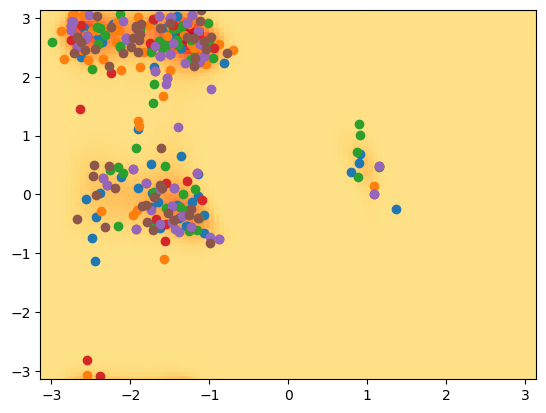

In [31]:
plt.hist2d(samples_2D_gen[:, 0], samples_2D_gen[:, 1], bins=100, density=True,cmap=light_cmap)

for i in range(8):
    if i != 6 and i !=3:
        plt.scatter(pca_dihedral[i][:50,0],pca_dihedral[i][:50,1])
# plt.scatter(samples_dihedral[1][:,0],samples_dihedral[1][:,1])
plt.show()

In [32]:
ee_pts_pca = []
rg_pts_pca = []
for i in range(8):
    ee_pt, rg_pt = compute_end_to_end_distance_and_rg_centered(close_points_list[i], masses)
    ee_pts_pca.append(ee_pt)
    rg_pts_pca.append(rg_pt)

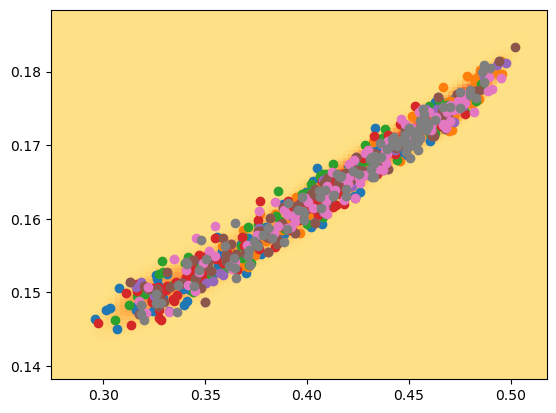

In [33]:
plt.hist2d(samples_2D_eer[:, 0], samples_2D_eer[:, 1], bins=100, density=True,cmap=light_cmap)
for i in range(8):
    plt.scatter(ee_pts_pca[i][:100],rg_pts_pca[i][:100])
plt.show()

In [34]:
x_samples = flow.draw_samples_from_prior(4000000).numpy()
Angles_psi = dihedral_angles(x_samples,[2,3,4,5])
Angles_phi = dihedral_angles(x_samples,[1,2,3,4])

In [35]:
train_set = np.load('./data/adjusted_data_500w.npy')[:4900000]
Angles_t_phi = dihedral_angles(train_set,[5, 7, 9, 15])
Angles_t_psi = dihedral_angles(train_set,[7, 9, 15,17])

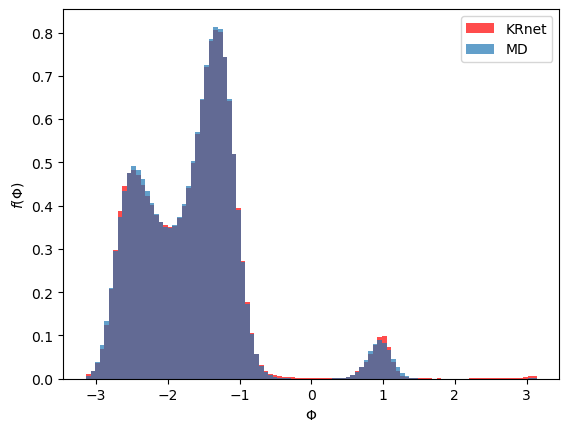

In [36]:
_ = plt.hist(Angles_phi, bins=np.linspace(min(Angles_psi),max(Angles_psi),100), alpha=0.7,density=True,label = 'KRnet',color='r')
_ = plt.hist(Angles_t_phi, bins=np.linspace(min(Angles_t_psi),max(Angles_t_psi),100), alpha=0.7,density=True,label = 'MD')
plt.ylabel(r'$f(\Phi)$')
plt.xlabel(r'$\Phi$')
plt.legend()

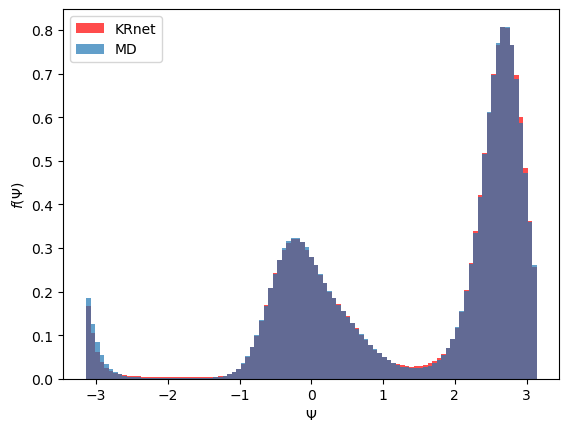

In [37]:
_ = plt.hist(Angles_psi, bins=np.linspace(min(Angles_psi),max(Angles_psi),100), alpha=0.7,density=True,label = 'KRnet',color='r')
_ = plt.hist(Angles_t_psi, bins=np.linspace(min(Angles_t_psi),max(Angles_t_psi),100), alpha=0.7,density=True,label = 'MD')
plt.ylabel(r'$f(\Psi)$')
plt.xlabel(r'$\Psi$')
plt.legend()


In [99]:
import itertools

def generate_grid_data(n_per_grid, n_x, n_y,z):
    # x_vals = np.linspace(-6, 5, n_x)  # Grid for first dimension
    x_vals = np.concatenate([
    np.linspace(-5, -2.5, n_x // 3, endpoint=False),
    np.linspace(0, 5, n_x - n_x // 3)])
    y_vals = np.linspace(-5, 7.5, n_y)  # Grid for second dimension

    grid_points = np.array(list(itertools.product(x_vals, y_vals)))  # Cartesian product of grid points
    
    all_data = []
    
    for x, y in grid_points:
        first_dim = np.full((n_per_grid, 1), x)
        second_dim = np.full((n_per_grid, 1), y)
        third_dim = np.full((n_per_grid, 1), z)
        remaining_dims = np.random.normal(0, 1, size=(n_per_grid, 12))
        
        data = np.hstack([first_dim, second_dim, third_dim, remaining_dims])
        all_data.append(data)
    
    all_data = np.vstack(all_data)  # Stack all grid points together
    return all_data

# Example usage
n_per_grid = 50000   # Number of samples per grid point
n_x, n_y = 10, 10  # Define grid resolution
zs =  np.concatenate([
    np.linspace(-4, -3, 45),
    np.linspace(2.5, 7.5, 5)
])

def compute_variances(data, chunk_size=50000):
    num_chunks = len(data) // chunk_size  # Number of complete chunks
    variances = np.array([np.var(data[i * chunk_size: (i + 1) * chunk_size]) for i in range(num_chunks)])
    return variances

variances_t = 0
for z in zs:
    data = generate_grid_data(n_per_grid, n_x, n_y,z)
    data = tf.convert_to_tensor(data,dtype=tf.float32)
    data_to_x = flow.mapping_from_prior(data)
    data_angles = dihedral_angles_tf(data_to_x,[1,2,3,4])
    variances = compute_variances(data_angles)
    variances_t += variances




In [100]:
x_vals = np.linspace(-6, 5, n_x)  # Grid for first dimension
y_vals = np.linspace(-5, 7.5, n_y)  # Grid for second dimension
    
grid_points = np.array(list(itertools.product(x_vals, y_vals))) 

In [101]:


def modify_data_grid(data, z, chunk_size=50000, dim4_range=(-3, 3), dim5_range=(-3, 3),n_dim4=10, n_dim5=10):
    """
    Modify data so that dimensions 4 and 5 follow a structured grid.
    
    Parameters:
        data (numpy.ndarray): The (5000000, 15) dataset.
        chunk_size (int): Number of samples sharing the same (dim4, dim5) values.
        dim4_range (tuple): Range for dimension 4.
        dim5_range (tuple): Range for dimension 5.
        n_dim4 (int): Number of grid points along dimension 4.
        n_dim5 (int): Number of grid points along dimension 5.
        
    Returns:
        numpy.ndarray: Modified dataset.
    """
    num_chunks = len(data) // chunk_size  # Total number of chunks
    
    # Create grid for dim4 and dim5
    dim4_vals = np.linspace(dim4_range[0], dim4_range[1], n_dim4)
    dim5_vals = np.linspace(dim5_range[0], dim5_range[1], n_dim5)
    
    # Generate all possible (dim4, dim5) pairs
    grid_points = np.array(list(itertools.product(dim4_vals, dim5_vals)))  # Shape: (n_dim4 * n_dim5, 2)
    
    # Ensure we don't exceed available grid points
    assert len(grid_points) >= num_chunks, "Increase grid resolution or reduce chunk size."
    
    # Modify data in chunks
    for i in range(num_chunks):
        data[i * chunk_size: (i + 1) * chunk_size, 3] = grid_points[i, 0]  # 4th dimension (index 3)
        data[i * chunk_size: (i + 1) * chunk_size, 4] = grid_points[i, 1]  # 5th dimension (index 4)
        data[i * chunk_size: (i + 1) * chunk_size, 5] = z  # 6th dimension (index 5)

    return data


# Example usage
zs = np.linspace(-3,3,50)
mvariances_t = 0

for z in zs:
    data_form_prior = draw_samples_from_prior(5000000).numpy()  # Simulated (5000000,15) data
    modified_data = modify_data_grid(data_form_prior,z)
    modified_data = tf.convert_to_tensor(modified_data,dtype=tf.float32)
    mdata_to_x = flow.mapping_from_prior(modified_data)
    mdata_angles = dihedral_angles_tf(mdata_to_x,[1,2,3,4])
    mvariances = compute_variances(mdata_angles)
    mvariances_t += mvariances


In [102]:

dim4_vals = np.linspace(-3, 3, 10)
dim5_vals = np.linspace(-3, 3, 10)
mgrid_points = np.array(list(itertools.product(dim4_vals, dim5_vals))) 


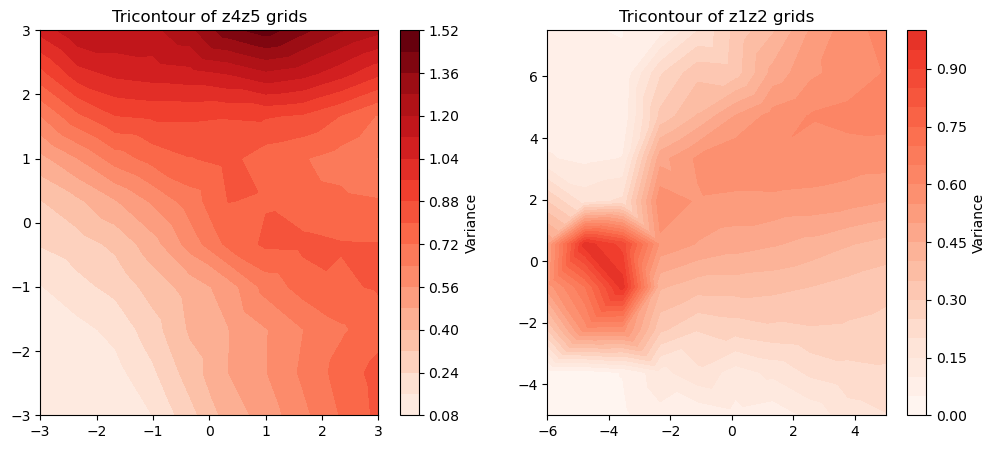

In [103]:
vmin = min(mvariances_t.min(), variances_t.min())/50
vmax = max(mvariances_t.max(), variances_t.max())/50

# Create figure
plt.figure(figsize=(12, 5))

# First tricontourf plot
plt.subplot(1, 2, 1)
contour1 = plt.tricontourf(mgrid_points[:, 0], mgrid_points[:, 1], mvariances_t/50, cmap='Reds', levels=20, vmin=vmin, vmax=vmax)
plt.colorbar(label="Variance")
plt.title("Tricontour of z4z5 grids")

# Second tricontourf plot
plt.subplot(1, 2, 2)
contour2 = plt.tricontourf(grid_points[:, 0], grid_points[:, 1], variances_t/50, cmap='Reds', levels=20, vmin=vmin, vmax=vmax)
plt.colorbar(label="Variance")
plt.title("Tricontour of z1z2 grids")

# Show the plots
plt.show()

In [48]:
for i in range(1,101):
    corr_d = np.load('./data/adjusted_dump_minus_cm_5atoms_'+str(i)+'.npy')
    z_raw = flow.mapping_to_prior(tf.constant(corr_d,dtype=tf.float32)).numpy()
    np.save('./data/corr_new_new/dump_'+str(i)+'.npy',z_raw)

In [50]:
import scipy.signal

def xcorr_tool(x, y=None, maxlag=None, scale='none'):
    """
    Compute auto-correlation or cross-correlation of signals.
    
    Parameters:
    - x: np.array (1D or 2D) → Input signal (if 2D, computes correlation for each column).
    - y: np.array (optional) → Second signal for cross-correlation (if None, computes auto-correlation).
    - maxlag: int (optional) → Maximum lag to compute.
    - scale: str (optional) → Scaling method:
        'none' (default) - No scaling
        'biased' - Scale by 1/M
        'unbiased' - Scale by 1/(M - |lags|)
        'coeff' - Normalize so the zero-lag auto-correlation is 1
    
    Returns:
    - c: np.array → Correlation values.
    - lags: np.array → Lag indices.
    """
    
    # Ensure x is a NumPy array
    x = np.asarray(x)
    
    # If no second signal is provided, compute auto-correlation
    if y is None:
        y = x
    
    # Compute cross-correlation using scipy.signal.correlate
    c = scipy.signal.correlate(x, y, mode='full', method='auto')

    # Get the maximum length of the signal
    M = len(x)
    
    # Define lag indices
    lags = np.arange(-M + 1, M)

    # Apply maxlag limit
    if maxlag is not None:
        maxlag = min(maxlag, M - 1)
        mid = len(c) // 2
        c = c[mid - maxlag: mid + maxlag + 1]
        lags = lags[mid - maxlag: mid + maxlag + 1]
    
    # Apply scaling
    if scale == 'biased':
        c = c / M
    elif scale == 'unbiased':
        c = c / (M - np.abs(lags))
    elif scale == 'coeff':
        c = c / np.max(np.abs(c))  # Normalize to have max value of 1

    return c, lags

# # Example Usage
# if __name__ == "__main__":
#     # Generate random signals
#     x = np.random.randn(100)
#     y = np.roll(x, 10)  # Shift x by 10 samples

#     # Compute cross-correlation
#     c, lags = xcorr_tool(x, y, maxlag=50, scale='coeff')

#     # Plot results
#     import matplotlib.pyplot as plt
#     plt.figure(figsize=(8, 4))
#     plt.plot(lags, c, marker='o', linestyle='-')
#     plt.xlabel("Lag")
#     plt.ylabel("Correlation")
#     plt.title("Cross-Correlation")
#     plt.grid(True

In [51]:
corr_0_t = 0
corr_1_t = 0
corr_2_t = 0

corr_10_t = 0
corr_11_t = 0
corr_12_t = 0

for i in range(1,101):
    z_values = np.load('./data/corr_new_new/dump_'+str(i)+'.npy')
    corr_0,_  = xcorr_tool(x = z_values[:,0],maxlag=20000, scale='unbiased')
    corr_1,_  = xcorr_tool(x = z_values[:,1],maxlag=20000, scale='unbiased')
    corr_2,_  = xcorr_tool(x = z_values[:,2],maxlag=20000, scale='unbiased')
    
    corr_10,_ = xcorr_tool(x = z_values[:,6],maxlag=20000, scale='unbiased')
    corr_11,_ = xcorr_tool(x = z_values[:,10],maxlag=20000, scale='unbiased')
    corr_12,_ = xcorr_tool(x = z_values[:,14],maxlag=20000, scale='unbiased')
    
    
    corr_0_t += corr_0
    corr_1_t += corr_1
    corr_2_t += corr_2

    corr_10_t += corr_10
    corr_11_t += corr_11
    corr_12_t += corr_12
    
corr_0_t /= 100
corr_1_t /= 100
corr_2_t /= 100

corr_10_t /= 100
corr_11_t /= 100
corr_12_t /= 100

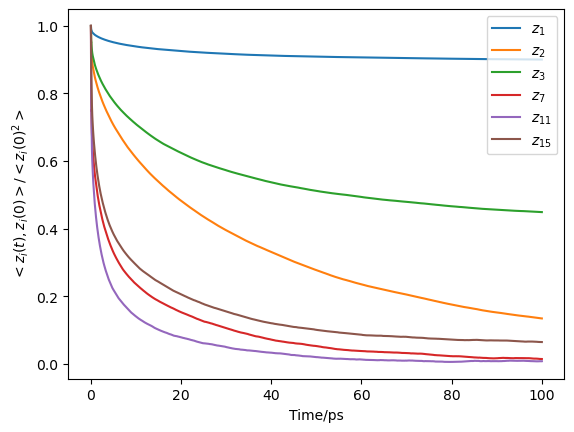

In [52]:
corr_0_s = (corr_0_t[20000::-1]+corr_0_t[20000::])/2
corr_1_s = (corr_1_t[20000::-1]+corr_1_t[20000::])/2
corr_2_s = (corr_2_t[20000::-1]+corr_2_t[20000::])/2

corr_10_s = (corr_10_t[20000::-1]+corr_10_t[20000::])/2
corr_11_s = (corr_11_t[20000::-1]+corr_11_t[20000::])/2
corr_12_s = (corr_12_t[20000::-1]+corr_12_t[20000::])/2



plt.plot([0.005*i for i in range(20001)],corr_0_s/corr_0_s[0],label=r'$z_1$')
plt.plot([0.005*i for i in range(20001)],corr_1_s/corr_1_s[0],label=r'$z_2$')
plt.plot([0.005*i for i in range(20001)],corr_2_s/corr_2_s[0],label=r'$z_3$')

plt.plot([0.005*i for i in range(20001)],corr_10_s/corr_10_s[0],label=r'$z_{7}$')
plt.plot([0.005*i for i in range(20001)],corr_11_s/corr_11_s[0],label=r'$z_{11}$')
plt.plot([0.005*i for i in range(20001)],corr_12_s/corr_12_s[0],label=r'$z_{15}$')
plt.legend()
plt.xlabel('Time/ps')
plt.ylabel(r'$<z_i(t),z_i(0)>/<z_i(0)^2>$')
plt.show()